In [1]:
#!pip install -U datasets

In [2]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification
from seqeval.metrics import f1_score, recall_score, precision_score, classification_report

from datasets import load_dataset

In [3]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

In [4]:
labels = ["O", "B-AC", "B-LF", "I-LF"]
n_labels = len(labels)
ltoi = {l: i for i, l in enumerate(labels)}
itol = {i: l for l, i in ltoi.items()}

In [5]:
model_checkpoint = "microsoft/deberta-v3-base" # Or deberta-v3-large, etc.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Check if the tokenizer is a fast tokenizer (it should be for DeBERTa-v3)
assert tokenizer.is_fast, "Only fast tokenizers are supported for this example."

/user/HS400/rh01555/.local/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [6]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True, # Crucial for pre-tokenized input
        max_length=512,
        padding="max_length"

    )

    labels = []
    for i, label_sequence in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None: # Special tokens ([CLS], [SEP])
                label_ids.append(-100)
            elif word_idx != previous_word_idx: # First token of a new word
                label_ids.append(ltoi[label_sequence[word_idx]])
            else: # Subsequent tokens of the same word
                label_ids.append(-100)


            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [7]:
t = tokenizer(["Dr. House administered the CPR."])
print(t.input_ids)
print(t.word_ids(0))

[[1, 1011, 260, 1097, 10028, 262, 20715, 260, 2]]
[None, 0, 0, 1, 2, 3, 4, 4, None]


In [8]:
data = dataset.map(tokenize_and_align_labels, batched = True)

In [9]:
train_data, train_labels, train_attention_mask = data['train']['input_ids'], data['train']['labels'], data['train']['attention_mask']
val_data, val_labels, val_attention_mask = data['validation']['input_ids'], data['validation']['labels'], data['validation']['attention_mask']
test_data, test_labels, test_attention_mask = data['test']['input_ids'], data['test']['labels'], data['test']['attention_mask']

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8

def get_batch(split = "train"):
  data = train_data if split == "train" else val_data
  labels = train_labels if split == "train" else val_labels
  attention_mask = train_attention_mask if split == "train" else val_attention_mask
  ix = torch.randint(len(data), (batch_size,))
  x = torch.stack([torch.tensor(data[i]).long() for i in ix])
  y = torch.stack([torch.tensor(labels[i]).long() for i in ix])
  a = torch.stack([torch.tensor(attention_mask[i]) for i in ix])
  return x.to(device), y.to(device), a.to(device)


@torch.no_grad()
def estimate_loss(eval_steps):
    out = {}
    model.eval()
    
    for split in ["train", "validation"]:
        losses = torch.zeros(eval_steps)
        correct_tokens = 0
        total_tokens = 0

        for k in range(eval_steps):
            x, y, a = get_batch(split)
            logits = model(x, attention_mask=a).logits
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1))
            losses[k] = loss.item()

            # Accuracy calculation
            preds = logits.argmax(dim=-1)
            mask = (y != -100)  # optional: ignore padding label if using -100
            correct = (preds == y) & mask
            correct_tokens += correct.sum().item()
            total_tokens += mask.sum().item()

        avg_loss = losses.mean().item()
        avg_acc = correct_tokens / total_tokens if total_tokens > 0 else 0.0
        out[split] = {"loss": avg_loss, "accuracy": avg_acc}

    model.train()
    return out


In [11]:
lre =torch.linspace(-6, -4, 1000)
lrs = 10**lre
#print(lrs)

In [12]:
def train_model(model, optimizer):
    train_loss_step = []
    train_acc_step = []
    val_loss_step = []
    val_acc_step = []
    eval_step = []

    max_steps = 1000

    for step in tqdm(range(max_steps)):
        x, y, a = get_batch("train")
        optimizer.zero_grad()
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            logits = model(x, attention_mask=a).logits
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1))
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            # Validation step
            metrics = estimate_loss(200)
            print(f"step {step}: "
                  f"train loss {metrics['train']['loss']:.4f}, acc {metrics['train']['accuracy']:.4f} | "
                  f"val loss {metrics['validation']['loss']:.4f}, acc {metrics['validation']['accuracy']:.4f}")
            train_loss_step.append(metrics['train']['loss'])
            train_acc_step.append(metrics['train']['accuracy'])
            val_loss_step.append(metrics['validation']['loss'])
            val_acc_step.append(metrics['validation']['accuracy'])
            eval_step.append(step)

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(eval_step, train_loss_step, label='Train Loss')
    plt.plot(eval_step, val_loss_step, label='Val Loss')
    plt.legend()
    plt.title("Loss over Steps")

    plt.subplot(1, 2, 2)
    plt.plot(eval_step, train_acc_step, label='Train Acc')
    plt.plot(eval_step, val_acc_step, label='Val Acc')
    plt.legend()
    plt.title("Accuracy over Steps")

    plt.show()

    return model

In [13]:
torch.set_float32_matmul_precision("high")

In [14]:
@torch.no_grad()
def evaluate_model(model, split="test"):
    """Evaluate model performance on given split with seqeval metrics"""
    model.eval()
    
    if split == "test":
        data_input_ids = test_data
        data_labels = test_labels
        data_attention_mask = test_attention_mask
    elif split == "validation":
        data_input_ids = val_data
        data_labels = val_labels
        data_attention_mask = val_attention_mask
    else:
        data_input_ids = train_data
        data_labels = train_labels
        data_attention_mask = train_attention_mask
    
    # Process in smaller batches to avoid OOM
    batch_size_eval = 16
    all_true_labels = []
    all_pred_labels = []
    
    # Process the entire dataset
    for i in tqdm(range(0, len(data_input_ids), batch_size_eval), desc=f"Evaluating on {split}"):
        # Get batch
        batch_input_ids = torch.tensor(data_input_ids[i:i+batch_size_eval]).to(device)
        batch_labels = torch.tensor(data_labels[i:i+batch_size_eval]).to(device)
        batch_attention_mask = torch.tensor(data_attention_mask[i:i+batch_size_eval]).to(device)
        
        # Get predictions
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        
        # Convert predictions and labels to lists for seqeval
        for j in range(len(batch_input_ids)):
            true_label_ids = batch_labels[j].cpu().numpy()
            pred_label_ids = predictions[j].cpu().numpy()
            
            # Convert IDs to labels, handling special tokens
            true_seq = []
            pred_seq = []
            
            for true_id, pred_id, mask in zip(true_label_ids, pred_label_ids, batch_attention_mask[j]):
                if mask == 1 and true_id != -100:  # Only evaluate on non-padding and non-special tokens
                    true_seq.append(itol[true_id.item()])
                    pred_seq.append(itol[pred_id.item()])
            
            if true_seq:  # Only add if not empty
                all_true_labels.append(true_seq)
                all_pred_labels.append(pred_seq)
    
    # Calculate metrics using seqeval
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    report = classification_report(all_true_labels, all_pred_labels)
    
    print(f"\n=== Evaluation on {split} split ===")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nDetailed Classification Report:")
    print(report)
    
    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "report": report
    }

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|                                                                                                                      | 1/1000 [00:27<7:44:15, 27.88s/it]

step 0: train loss 1.0827, acc 0.7575 | val loss 1.1575, acc 0.7380


 10%|███████████▋                                                                                                        | 101/1000 [01:16<2:08:21,  8.57s/it]

step 100: train loss 0.8318, acc 0.7530 | val loss 0.8310, acc 0.7492


 20%|███████████████████████▎                                                                                            | 201/1000 [02:04<1:54:09,  8.57s/it]

step 200: train loss 0.8596, acc 0.7477 | val loss 0.8653, acc 0.7458


 30%|██████████████████████████████████▉                                                                                 | 301/1000 [02:53<1:39:56,  8.58s/it]

step 300: train loss 0.8146, acc 0.7640 | val loss 0.8519, acc 0.7479


 40%|██████████████████████████████████████████████▌                                                                     | 401/1000 [03:41<1:25:32,  8.57s/it]

step 400: train loss 0.8309, acc 0.7582 | val loss 0.8717, acc 0.7360


 50%|██████████████████████████████████████████████████████████                                                          | 501/1000 [04:30<1:11:12,  8.56s/it]

step 500: train loss 0.8344, acc 0.7551 | val loss 0.8540, acc 0.7455


 60%|██████████████████████████████████████████████████████████████████████▉                                               | 601/1000 [05:18<56:57,  8.57s/it]

step 600: train loss 0.8232, acc 0.7581 | val loss 0.8515, acc 0.7424


 70%|██████████████████████████████████████████████████████████████████████████████████▋                                   | 701/1000 [06:06<42:48,  8.59s/it]

step 700: train loss 0.8267, acc 0.7572 | val loss 0.8373, acc 0.7506


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▌                       | 801/1000 [06:55<28:25,  8.57s/it]

step 800: train loss 0.8200, acc 0.7610 | val loss 0.8552, acc 0.7438


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 901/1000 [07:43<14:08,  8.57s/it]

step 900: train loss 0.8176, acc 0.7576 | val loss 0.8530, acc 0.7413


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:04<00:00,  2.07it/s]


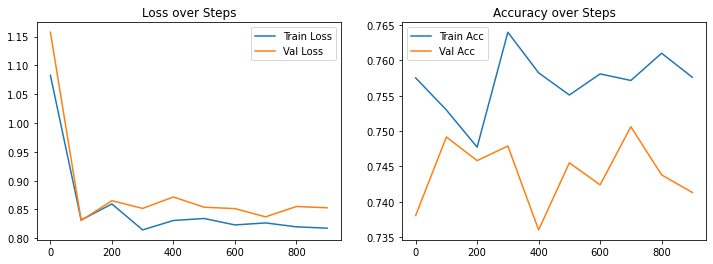

Evaluating on test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.46it/s]
/user/HS400/rh01555/.local/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/rh01555/.local/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



=== Evaluation on test split ===
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000

Detailed Classification Report:
              precision    recall  f1-score   support

          AC       0.00      0.00      0.00       797
          LF       0.00      0.00      0.00       482

   micro avg       0.00      0.00      0.00      1279
   macro avg       0.00      0.00      0.00      1279
weighted avg       0.00      0.00      0.00      1279



/user/HS400/rh01555/.local/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=n_labels,
    id2label=itol,
    label2id=ltoi
).to(device)
model = torch.compile(model)

optim = torch.optim.AdamW(model.parameters(), lr = 3e-4)
model = train_model(model, optim)
out = evaluate_model(model)

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|                                                                                                                      | 1/1000 [00:27<7:43:20, 27.83s/it]

step 0: train loss 1.6920, acc 0.1566 | val loss 1.7067, acc 0.1594


 10%|███████████▋                                                                                                        | 101/1000 [01:13<2:08:10,  8.55s/it]

step 100: train loss 0.7664, acc 0.7561 | val loss 0.7984, acc 0.7409


 20%|███████████████████████▎                                                                                            | 201/1000 [01:58<1:53:54,  8.55s/it]

step 200: train loss 0.6315, acc 0.7760 | val loss 0.6553, acc 0.7676


 30%|██████████████████████████████████▉                                                                                 | 301/1000 [02:43<1:39:37,  8.55s/it]

step 300: train loss 0.5479, acc 0.8060 | val loss 0.5724, acc 0.7953


 40%|██████████████████████████████████████████████▌                                                                     | 401/1000 [03:29<1:25:23,  8.55s/it]

step 400: train loss 0.4891, acc 0.8260 | val loss 0.5270, acc 0.8043


 50%|██████████████████████████████████████████████████████████                                                          | 501/1000 [04:14<1:11:11,  8.56s/it]

step 500: train loss 0.4366, acc 0.8454 | val loss 0.4785, acc 0.8182


 60%|██████████████████████████████████████████████████████████████████████▉                                               | 601/1000 [05:00<56:57,  8.56s/it]

step 600: train loss 0.4146, acc 0.8501 | val loss 0.4499, acc 0.8279


 70%|██████████████████████████████████████████████████████████████████████████████████▋                                   | 701/1000 [05:45<42:38,  8.56s/it]

step 700: train loss 0.3877, acc 0.8596 | val loss 0.4442, acc 0.8271


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▌                       | 801/1000 [06:31<28:22,  8.55s/it]

step 800: train loss 0.3696, acc 0.8666 | val loss 0.4026, acc 0.8441


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 901/1000 [07:16<14:06,  8.55s/it]

step 900: train loss 0.3710, acc 0.8629 | val loss 0.3993, acc 0.8455


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:33<00:00,  2.20it/s]


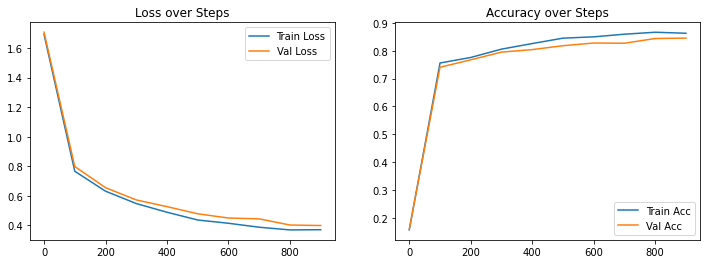

Evaluating on test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.45it/s]



=== Evaluation on test split ===
F1 Score: 0.6646
Precision: 0.6607
Recall: 0.6685

Detailed Classification Report:
              precision    recall  f1-score   support

          AC       0.84      0.72      0.78       797
          LF       0.46      0.59      0.52       482

   micro avg       0.66      0.67      0.66      1279
   macro avg       0.65      0.65      0.65      1279
weighted avg       0.70      0.67      0.68      1279



In [16]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=n_labels,
    id2label=itol,
    label2id=ltoi
).to(device)
model = torch.compile(model)

optim = torch.optim.SGD(model.parameters(), lr = 3e-4)
model = train_model(model, optim)
out = evaluate_model(model)

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|                                                                                                                      | 1/1000 [00:27<7:44:59, 27.93s/it]

step 0: train loss 0.9521, acc 0.7549 | val loss 0.9905, acc 0.7428


 10%|███████████▋                                                                                                        | 101/1000 [01:15<2:08:18,  8.56s/it]

step 100: train loss 0.8303, acc 0.7586 | val loss 0.8492, acc 0.7427


 20%|███████████████████████▎                                                                                            | 201/1000 [02:02<1:54:13,  8.58s/it]

step 200: train loss 0.8874, acc 0.7499 | val loss 0.8764, acc 0.7487


 30%|██████████████████████████████████▉                                                                                 | 301/1000 [02:49<1:39:56,  8.58s/it]

step 300: train loss 0.8530, acc 0.7481 | val loss 0.8470, acc 0.7479


 40%|██████████████████████████████████████████████▌                                                                     | 401/1000 [03:36<1:25:34,  8.57s/it]

step 400: train loss 0.8583, acc 0.7535 | val loss 0.8683, acc 0.7452


 50%|██████████████████████████████████████████████████████████                                                          | 501/1000 [04:23<1:11:17,  8.57s/it]

step 500: train loss 0.9073, acc 0.7443 | val loss 0.9080, acc 0.7431


 60%|██████████████████████████████████████████████████████████████████████▉                                               | 601/1000 [05:11<56:59,  8.57s/it]

step 600: train loss 0.7953, acc 0.7663 | val loss 0.8675, acc 0.7311


 70%|██████████████████████████████████████████████████████████████████████████████████▋                                   | 701/1000 [05:58<42:49,  8.59s/it]

step 700: train loss 0.2705, acc 0.9149 | val loss 0.3411, acc 0.8919


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▌                       | 801/1000 [06:45<28:25,  8.57s/it]

step 800: train loss 0.2672, acc 0.9109 | val loss 0.3157, acc 0.8970


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 901/1000 [07:32<14:08,  8.57s/it]

step 900: train loss 0.2023, acc 0.9232 | val loss 0.2666, acc 0.9043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:52<00:00,  2.12it/s]


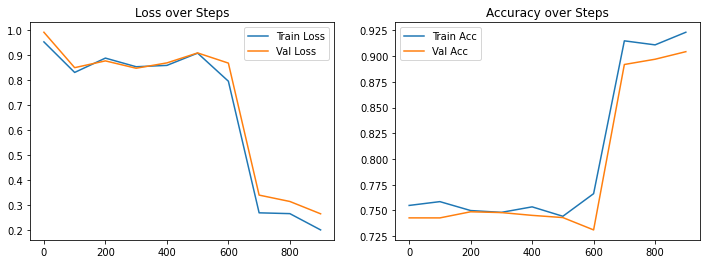

Evaluating on test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.47it/s]



=== Evaluation on test split ===
F1 Score: 0.8327
Precision: 0.7938
Recall: 0.8757

Detailed Classification Report:
              precision    recall  f1-score   support

          AC       0.85      0.91      0.88       797
          LF       0.71      0.82      0.76       482

   micro avg       0.79      0.88      0.83      1279
   macro avg       0.78      0.86      0.82      1279
weighted avg       0.80      0.88      0.83      1279



In [17]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=n_labels,
    id2label=itol,
    label2id=ltoi
).to(device)
model = torch.compile(model)

optim = torch.optim.RMSprop(model.parameters(), lr = 3e-5)
model = train_model(model, optim)
out = evaluate_model(model)

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|                                                                                                                      | 1/1000 [00:27<7:43:56, 27.86s/it]

step 0: train loss 1.3099, acc 0.4018 | val loss 1.3263, acc 0.3961


 10%|███████████▋                                                                                                        | 101/1000 [01:16<2:08:29,  8.58s/it]

step 100: train loss 0.1787, acc 0.9338 | val loss 0.2535, acc 0.9088


 20%|███████████████████████▎                                                                                            | 201/1000 [02:04<1:54:15,  8.58s/it]

step 200: train loss 0.1722, acc 0.9367 | val loss 0.2643, acc 0.9140


 30%|██████████████████████████████████▉                                                                                 | 301/1000 [02:53<1:39:57,  8.58s/it]

step 300: train loss 0.1482, acc 0.9458 | val loss 0.2444, acc 0.9206


 40%|██████████████████████████████████████████████▌                                                                     | 401/1000 [03:41<1:25:43,  8.59s/it]

step 400: train loss 0.1440, acc 0.9507 | val loss 0.3003, acc 0.9052


 50%|██████████████████████████████████████████████████████████                                                          | 501/1000 [04:30<1:11:24,  8.59s/it]

step 500: train loss 0.1198, acc 0.9562 | val loss 0.2256, acc 0.9198


 60%|██████████████████████████████████████████████████████████████████████▉                                               | 601/1000 [05:19<57:05,  8.59s/it]

step 600: train loss 0.1105, acc 0.9599 | val loss 0.2495, acc 0.9097


 70%|██████████████████████████████████████████████████████████████████████████████████▋                                   | 701/1000 [06:07<42:47,  8.59s/it]

step 700: train loss 0.0967, acc 0.9659 | val loss 0.2483, acc 0.9184


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▌                       | 801/1000 [06:56<28:28,  8.58s/it]

step 800: train loss 0.0982, acc 0.9658 | val loss 0.2276, acc 0.9255


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 901/1000 [07:44<14:09,  8.58s/it]

step 900: train loss 0.0766, acc 0.9721 | val loss 0.2488, acc 0.9221


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:05<00:00,  2.06it/s]


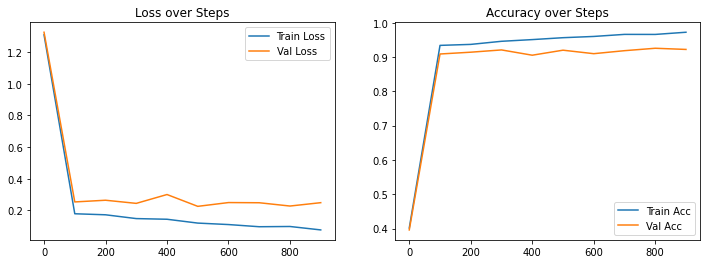

Evaluating on test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.45it/s]



=== Evaluation on test split ===
F1 Score: 0.8346
Precision: 0.8234
Recall: 0.8460

Detailed Classification Report:
              precision    recall  f1-score   support

          AC       0.89      0.88      0.88       797
          LF       0.72      0.80      0.76       482

   micro avg       0.82      0.85      0.83      1279
   macro avg       0.81      0.84      0.82      1279
weighted avg       0.83      0.85      0.84      1279



In [18]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=n_labels,
    id2label=itol,
    label2id=ltoi
).to(device)
model = torch.compile(model)

optim = torch.optim.AdamW(model.parameters(), lr = 3e-5)
model = train_model(model, optim)
out = evaluate_model(model)